In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import sinkhorn as skh
import oracles as oracle
import model as md
import time
import pickle

In [2]:
np.version.version

'1.18.2'

In [3]:
net_name = 'data/EMA_net.tntp'
trips_name = 'data/EMA_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 3, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

In [4]:
df = graph_data['graph_table']
df[df['Init node'] == 1].head()

,Init node,Term node,Capacity,length,Free Flow Time
0,1,3,4938.061523,16.106817,0.238965
2,1,7,7309.824707,16.058741,0.222813
4,1,9,1164.374878,17.455400,0.402046


In [6]:
correspondence_matrix = handler.from_dict_to_cor_matr(graph_correspondences, n)
T = handler.create_C(df, n, column_name='Free Flow Time')
# C = handler.create_C(df, n, column_name='length')
np.savetxt('data/T.csv', T, delimiter=',')

L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = handler.distributor_L_W(L)
W = handler.distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)

print('people_num: ', people_num)

people_num:  65576.37543100001


In [7]:
T[0][6]

0.22281299531459808

##### Подумаем над T
В данных по Москве время в минутах. В этих данных время по часам! ('Time: hours, distance: miles'). Поэтому альфа получается таким большим, оно масштабирует. В Москве время было в минутах. Также в T много нулей, поэтому там, где стоят nan, поставим по 100 часов, типа много затрат и поэтому никто так не ездит (сделано там, где инициализируется cost_matrix)

##### Запускаем Синхорна

In [8]:
num_iter = 2500
alpha, beta = 1.0, 1.0
alpha_range  = np.arange(0.0, 7500.0, 50.0)

best_matrix = None
min_reconstruction_error = np.inf
best_alpha, best_beta = np.nan, np.nan
eps = 10**(-3)

s = skh.Sinkhorn(n, L, W, people_num, num_iter, eps)

er_list = []

for alpha_idx in range(len(alpha_range)):
    alpha = alpha_range[alpha_idx]
    cost_matrix = np.nan_to_num(T * alpha, nan=100)
    rec = s.iterate(cost_matrix)
        
    er = np.linalg.norm(rec - np.nan_to_num(correspondence_matrix, nan=0.0))
    er = np.sqrt( er / np.sum(np.nan_to_num(correspondence_matrix, nan=0.0)) )
    er_list.append(er)

    if er < min_reconstruction_error:
        min_reconstruction_error = er
        best_alpha  = alpha_range[alpha_idx]
        best_matrix = rec

In [9]:
min_reconstruction_error

0.2522415873969528

In [10]:
er_list[0] - min_reconstruction_error

0.0839752035245645

In [11]:
best_alpha

7450.0

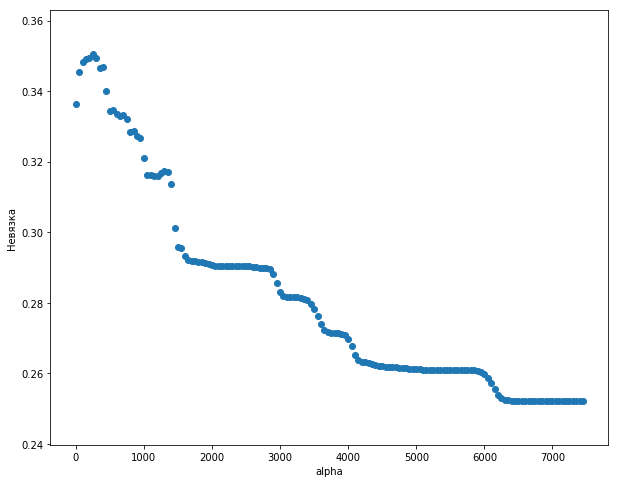

In [12]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(alpha_range, er_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()
fig.savefig('KEV_res/EMA' + str(len(alpha_range)) + '.png')

##### Best recovery corr matrix  

In [ ]:
for line in best_matrix:
    print(line)